# RNN - 循环神经网络
<img alt="image.png" height="600" src="/Users/loneker/Desktop/d2l/pic/iShot_2024-05-14_02.19.51.png" width="900"/>

输出Ot是通过隐变量Ht预测出来的结果，输出是发生在观察之前，输出的时候是看不到当前时刻的观察
Xt-1来更新Ot
通过比较Ot和Xt之间的关系来计算损失
RNN中Whh用来存储全部的时序信息

## 困惑度(perplexity)
衡量一个语言模型的好坏可以使用平均交叉熵
<img alt="image.png" height="600" src="/Users/loneker/Desktop/d2l/pic/iShot_2024-05-14_02.36.39.png" width="900"/>

## 梯度裁剪
g是所有层的梯度
<img alt="image.png" height="600" src="/Users/loneker/Desktop/d2l/pic/iShot_2024-05-14_02.44.47.png" width="900"/>

# 循环神经网络的从零开始实现

In [2]:
%matplotlib inline
import torch
import math
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# num_steps: 每一次取长度为 num_steps 长的序列
batch_size, num_steps = 32, 35
# vocab 实现词和idx的相互转换
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
# 独热编码, 将一个token变成一个向量，之前是按char来做的vocab，所以len(vocab)是28(26个字母+空格+unk)
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [4]:
# 小批量数据形状是(批量大小，时间步数),(32 * 35)
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape
# 转置之后第一维就是时间维度，可以满足时序关系，实现并行计算

torch.Size([5, 2, 28])

In [5]:
# 初始化循环神经网络模型的模型参数
def get_params(vocab_size, num_hiddens, device) : 
    num_inputs = num_outputs = vocab_size       # 经过独热编码后变成一个向量，输入输出的长度都是len(vocab)
    
    def normal(shape) :
        return torch.randn(size=shape, device = device) * 0.01      # 生成均值为0，方差为1的随机数向量
    
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)       # 每一个隐藏单元都有一个偏置
    W_hq = normal((num_hiddens, num_outputs))           # 隐藏变量到输出
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params : 
        param.requires_grad_(True)
    return params

In [6]:
# 初始化隐藏状态
def init_rnn_state(batch_size, num_hiddens, device) : 
    return (torch.zeros((batch_size, num_hiddens), device=device), )    # 做成一个元组，方便于后面lstm统一

In [7]:
# 计算
# 输入、隐藏状态、可学习的参数
def rnn(inputs, state, params) :
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs :       # inputs.shape : (T, batch_size, vocab_size), for X : 沿着第一个维度(T)进行循环
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h) # H 相当于前一个时间的隐藏状态
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim = 0), (H, )       # 将输出按行拼起来，列数还是vocab.size, 并返回隐藏状态以供后面使用

In [9]:
# 创建一个类来包装这些函数
class RNNModelScratch : 
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)   # forward之后得到输出和更新后的隐藏状态
    
    def begin_state(self, batch_size, device):
        # 这里是定义在调用RNNModelScratch时会传入init_rnn_model这个函数作为参数
        return self.init_state(batch_size, self.num_hiddens, device) 

In [11]:
# 检查输出是否具有正确的形状
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
# X.shape:(2, 5), 2个批量，每一个批量长度为五个时间步，每个时间步对应一个输出，并且将2个批量的输出拼在一起，所以Y.shape:(10, 28)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
# state 是一个元组，第一个元素为隐藏层变量，形状为：批量大小 * 隐藏层大小
Y.shape, len(new_state), new_state[0].shape 

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [14]:
# 定义预测函数来生成prefix之后的新字符
def predict_ch8(prefix, num_preds, net, vocab, device) : 
    # 对一个字符串做预测，所以batch_size = 1
    state = net.begin_state(batch_size=1, device=device)
    # outputs就是将预测出的token转换成词之后的结果
    outputs = [vocab[prefix[0]]]
    # 匿名函数, 将预测的输出当作下一时刻的输入
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    
    # 这个forloop是将prefix的信息全部放到state里面，现在不是预测阶段
    for y in prefix[1: ] :
        _, state = net(get_input(), state)      # 现在并不care预测结果
        outputs.append(vocab[y])                # 所以将真实的结果放入到输出里
    
    # 预测
    for _ in range(num_preds) : 
        y , state = net(get_input(), state)
        outputs.append(int(y.argmax(dim = 1).reshape(1)))
    return ''.join(vocab.idx_to_token[i] for i in outputs)

predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller xawilyebdn'

In [15]:
# 梯度裁剪
def grad_clipping(net, theta) : 
    # 将所有可训练的参数拿出来
    if isinstance(net, nn.Module) : 
        params = [p for p in net.parameters() if p.requires_grad]
    else :
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta : 
        for param in params:
            param.grad[:] *= theta / norm

In [17]:
# 定义一个函数在一个迭代周期内训练模型，刚才已经定义了在一个batch和一个iter中怎么做
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:    
            # 如果使用随机抽样，上一个batch的sequence和这个batch的不连续，所以要重新设置state
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                # 顺序抽样时，state用的上次得到的结果来做初始化。如果不detach的话，他就会保留上一次运算的梯度，但是我们只要这个数值来做初始化，而不需要他之前的梯度，所以要detach
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)     # 将时间放到前面的维度
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean() 
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()
    # 困惑度

In [21]:
# 循环神经网络模型的训练函数既支持从零开始实现，也可以使用高级API来实现
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()        # 虽然是语言模型，但实际是一个多分类问题
    # 动画
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])
    
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 58832.0 词元/秒 cpu
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


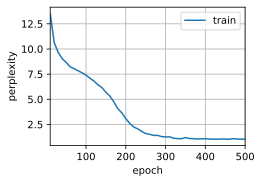

In [22]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.5, 57578.0 词元/秒 cpu
time travellerit s against reason said filby of course a solid b
travellerit s against reason said filby of course a solid b


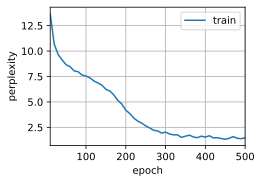

In [23]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter =True)

# 循环神经网络的简洁实现

In [24]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [32]:
len(vocab)

28

In [25]:
# 定义模型
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [26]:
# 使用张量来初始化隐藏状态
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

[**通过一个隐状态和一个输入，我们就可以用更新后的隐状态计算输出。**]
需要强调的是，`rnn_layer`的“输出”（`Y`）不涉及输出层的计算：
它是指每个时间步的隐状态，这些隐状态可以用作后续输出层的输入。


In [28]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape
#  torch.rnn与自己实现的RNN有所不同，这里是没有输出层，所以Y的形状的最后一维是隐藏层单元数

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [29]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            # 输出层
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)       
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [30]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellercbbvbbvbbv'

perplexity 1.3, 187486.7 tokens/sec on cpu
time traveller after the pauserequired for the proper assimilati
travellerit would be remarkably convedientifie that sabet u


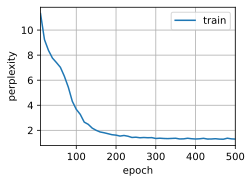

In [31]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)